# Exploration + Grouping by State

In [ ]:
# The first several kernels are an exploration of the data
# The data was by state only
# K means was executed on the mean request from medicare and payment recieved as well as the percent recieved (payment/request)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score


In [2]:
#Import data 
missing_values = ["n/a", "na", "--"]
medicaredf = pd.read_csv("Medicare_Provider_Util_Payment_PUF_CY2017.txt",sep='	',na_values = missing_values)
print(medicaredf.head())

#Understanding basic info about data

medicaredf.columns #26 columns
medicaredf.shape #9,847,444 rows
medicaredf.info()
medicaredf.describe()
print(medicaredf.isnull().sum())
#remove outliers (amount requested from medicare should never be smaller than the amount recieved)
medicaredf["percentage"]=medicaredf['average_Medicare_payment_amt']/medicaredf['average_submitted_chrg_amt']
medicaredf=medicaredf[medicaredf["percentage"]<1]
print(medicaredf.head())

/Users/anna2/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


          npi                       nppes_provider_last_org_name  \
0           1  CPT copyright 2016 American Medical Associatio...   
1  1003000126                                          ENKESHAFI   
2  1003000126                                          ENKESHAFI   
3  1003000126                                          ENKESHAFI   
4  1003000126                                          ENKESHAFI   

  nppes_provider_first_name nppes_provider_mi nppes_credentials  \
0                       NaN               NaN               NaN   
1                   ARDALAN               NaN              M.D.   
2                   ARDALAN               NaN              M.D.   
3                   ARDALAN               NaN              M.D.   
4                   ARDALAN               NaN              M.D.   

  nppes_provider_gender nppes_entity_code nppes_provider_street1  \
0                   NaN               NaN                    NaN   
1                     M                 I           

In [3]:
pd.get_dummies(medicaredf['nppes_provider_state'],prefix='State')
#print(pd.get_dummies(medicaredf['nppes_provider_state'],prefix='State').head())
medicaredf = pd.concat([medicaredf,pd.get_dummies(medicaredf['nppes_provider_state'],prefix='State')],axis=1)
print(medicaredf.head())
#Not dropping "nppes_provider_state" because it is easier to compare categorically later

          npi nppes_provider_last_org_name nppes_provider_first_name  \
1  1003000126                    ENKESHAFI                   ARDALAN   
2  1003000126                    ENKESHAFI                   ARDALAN   
3  1003000126                    ENKESHAFI                   ARDALAN   
4  1003000126                    ENKESHAFI                   ARDALAN   
5  1003000126                    ENKESHAFI                   ARDALAN   

  nppes_provider_mi nppes_credentials nppes_provider_gender nppes_entity_code  \
1               NaN              M.D.                     M                 I   
2               NaN              M.D.                     M                 I   
3               NaN              M.D.                     M                 I   
4               NaN              M.D.                     M                 I   
5               NaN              M.D.                     M                 I   

  nppes_provider_street1 nppes_provider_street2 nppes_provider_city  ...  \
1   

In [20]:
#Removing non-US states - Commented out rows are due to previous subsections
medicaredf = medicaredf[medicaredf.State_XX != 1]
medicaredf = medicaredf[medicaredf.State_AA != 1]
medicaredf = medicaredf[medicaredf.State_AP != 1]
medicaredf =medicaredf[medicaredf.State_AS != 1]
medicaredf = medicaredf[medicaredf.State_GU != 1]
medicaredf = medicaredf[medicaredf.State_MP != 1]
medicaredf = medicaredf[medicaredf.State_PR != 1]
medicaredf = medicaredf[medicaredf.State_VI != 1]
medicaredf = medicaredf[medicaredf.State_ZZ != 1]
medicaredf = medicaredf[medicaredf.State_DC != 1]
#state=df['state']

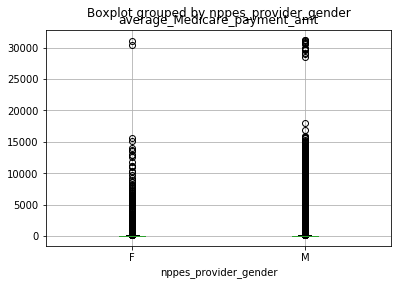

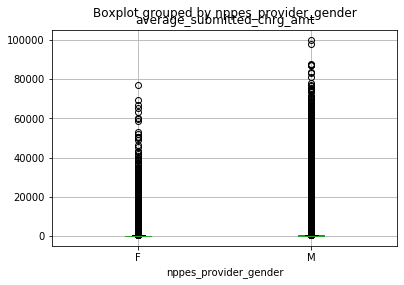

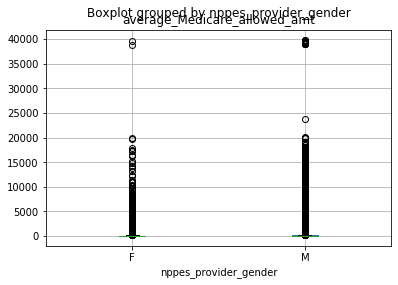

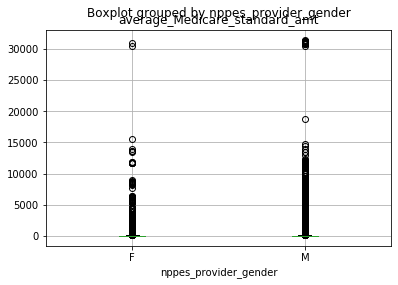

In [60]:
#Exploring provider gender vs medicare payment amounts

medicaredf.boxplot(column='average_Medicare_payment_amt', by='nppes_provider_gender')
medicaredf.boxplot(column='average_submitted_chrg_amt', by='nppes_provider_gender')
medicaredf.boxplot(column='average_Medicare_allowed_amt', by='nppes_provider_gender')
medicaredf.boxplot(column='average_Medicare_standard_amt', by='nppes_provider_gender')

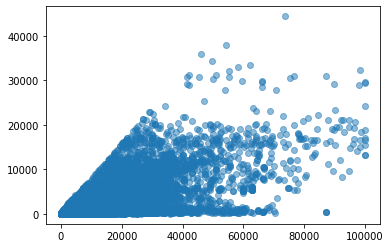

In [61]:
#Exploring medicare request vs medicare payment 
payment=medicaredf['average_Medicare_payment_amt']
request=medicaredf['average_submitted_chrg_amt']

plt.scatter(request, payment, alpha=0.5)

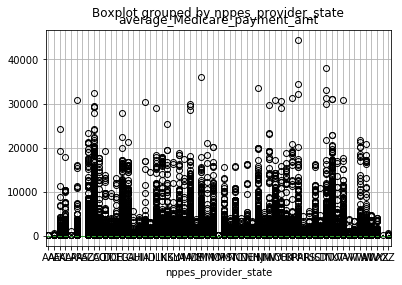

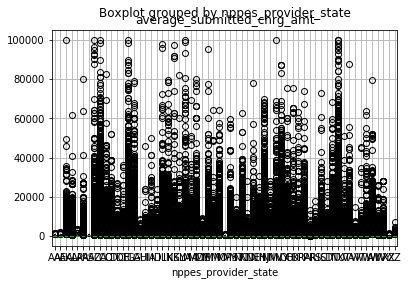

In [62]:
#Exploring state vs medicare payment
medicaredf.boxplot(column='average_Medicare_payment_amt', by='nppes_provider_state')
medicaredf.boxplot(column='average_submitted_chrg_amt', by='nppes_provider_state')

In [51]:
#Create new dataframe of npi, state, Medicare amount requested, and amount paid (df)
df=medicaredf.iloc[: , [0, 11, 23, 24]].copy() 
df.columns= ["npi","state", "request", "payment"]


In [52]:
#Remove rows where state is NaN because exploring how the state/ region affects the medicare payments and missing state will create unknown data points
df = df[pd.notnull(df["state"])]
print(df.head(15))
#Remove rows where payment/request>1 because this means they recieved more than they asked for which should not be the case and these will be outliers
df["percentage"]=df["payment"]/df["request"]
df=df[df["percentage"]<1]
print(df.head(15))

           npi state      request     payment
1   1003000126    MD   325.780000   56.827200
2   1003000126    MD   449.000000   78.460000
3   1003000126    MD   614.000000  102.807692
4   1003000126    MD   755.932203  141.293559
5   1003000126    MD   462.812500   79.710000
6   1003000126    MD   625.000000  105.825424
7   1003000126    MD   923.991228  160.377193
8   1003000126    MD   326.245614   56.366730
9   1003000126    MD   461.072464   82.820676
10  1003000126    MD   481.686217   84.056158
11  1003000126    MD  1400.000000  175.750000
12  1003000134    IL   115.000000    9.842127
13  1003000134    IL   170.000000   31.426415
14  1003000134    IL    88.000000   22.700525
15  1003000134    IL    68.000000   10.298140
           npi state      request     payment  percentage
1   1003000126    MD   325.780000   56.827200    0.174434
2   1003000126    MD   449.000000   78.460000    0.174744
3   1003000126    MD   614.000000  102.807692    0.167439
4   1003000126    MD   755.93220

In [41]:
#Create new dataframe of credentials, Medicare amount requested, and amount paid (creddf)
creddf=medicaredf.iloc[: , [4, 23, 24]].copy() 
creddf.columns= ["credentials", "payment", "request"]
#Remove rows where state is NaN because exploring how the credentials affects the medicare payments
creddf = creddf[pd.notnull(creddf["credentials"])]
print(creddf.head(15))
#Group by credentials taking mean of payment and request
credentials = creddf.groupby("credentials")["payment","request"].mean()
print(credentials.head())
#del medicaredf
#gc.collect()

   credentials      payment     request
1         M.D.   325.780000   56.827200
2         M.D.   449.000000   78.460000
3         M.D.   614.000000  102.807692
4         M.D.   755.932203  141.293559
5         M.D.   462.812500   79.710000
6         M.D.   625.000000  105.825424
7         M.D.   923.991228  160.377193
8         M.D.   326.245614   56.366730
9         M.D.   461.072464   82.820676
10        M.D.   481.686217   84.056158
11        M.D.  1400.000000  175.750000
12        M.D.   115.000000    9.842127
13        M.D.   170.000000   31.426415
14        M.D.    88.000000   22.700525
15        M.D.    68.000000   10.298140
                       payment     request
credentials                               
(D.C.) CHIROPRACTIC   54.00000   30.555478
(D.C.) CHIROPRACTOR   51.97798   27.012569
(LCSW)                90.00000   63.167065
(PA)                 523.00000  157.380000
(PHD) LICSW          160.00000   47.666800


In [67]:
#Realizing there are many different credentials, looking at unique strings in credentials
creddf['credentials'].nunique()

15985

In [46]:
#Examining the data, there are multiple rows for one provider, so create a new data frame that groups by npi and takes the mean of medicare request and payment. Use the state that corresponds to the npi.
#Remove rows where state is NaN because exploring how the state/ region affects the medicare payments and missing state will create unknown data points
df = df[pd.notnull(df["state"])]
#Groups by npi and takes mean of request and payment
indvdf = df.groupby("npi")["request","payment"].mean()

In [45]:
#Groups by npi and takes mean of request and payment
indvdf = df.groupby("npi")["request","payment"].mean()
print(indvdf)#1032911 rows x 2 columns

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:
#Creating a new state column to match the new df so that only one row state is saved for each npi
state=df.drop_duplicates(subset="npi", keep='first') 

#Fix index for both df
newdf=state.iloc[: ,[0,1]].copy() 
newdf=newdf.reset_index(drop=True)
print(newdf)
indvdf=indvdf.reset_index(drop=True)

#combine the two df
result = pd.concat([newdf,indvdf], axis=1, join='outer', ignore_index=True)
result.columns= ["npi", "state", "request", "payment"]
print(result)

                npi state
0        1003000126    MD
1        1003000134    IL
2        1003000142    OH
3        1003000407    PA
4        1003000423    OH
...             ...   ...
1032901  1992999551    CA
1032902  1992999759    GA
1032903  1992999775    OR
1032904  1992999825    WA
1032905  1992999874    VA

[1032906 rows x 2 columns]
                npi state      request     payment
0        1003000126    MD   620.501839  102.208603
1        1003000134    IL   145.292490   29.411867
2        1003000142    OH   208.206061   82.999827
3        1003000407    PA   154.495922   87.430694
4        1003000423    OH    57.500000   41.356341
...             ...   ...          ...         ...
1032901  1992999551    CA   159.035217   64.595646
1032902  1992999759    GA   151.873333   39.286686
1032903  1992999775    OR  2696.363636  617.903672
1032904  1992999825    WA   533.750000  130.093765
1032905  1992999874    VA   297.000000  138.041355

[1032906 rows x 4 columns]


          npi state     request     payment  percentage
0  1003000126    MD  620.501839  102.208603    0.164719
1  1003000134    IL  145.292490   29.411867    0.202432
2  1003000142    OH  208.206061   82.999827    0.398643
3  1003000407    PA  154.495922   87.430694    0.565909
4  1003000423    OH   57.500000   41.356341    0.719241
                npi state      request     payment  percentage
0        1003000126    MD   620.501839  102.208603    0.164719
1        1003000134    IL   145.292490   29.411867    0.202432
2        1003000142    OH   208.206061   82.999827    0.398643
3        1003000407    PA   154.495922   87.430694    0.565909
4        1003000423    OH    57.500000   41.356341    0.719241
...             ...   ...          ...         ...         ...
1032901  1992999551    CA   159.035217   64.595646    0.406172
1032902  1992999759    GA   151.873333   39.286686    0.258681
1032903  1992999775    OR  2696.363636  617.903672    0.229162
1032904  1992999825    WA   533.75

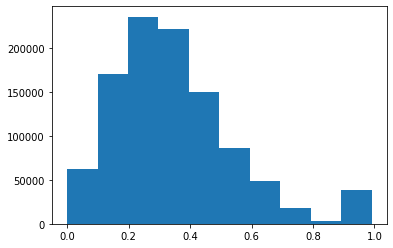

In [8]:
#create "percentage" column which is the percentage of the requested medicare amount that was paid
result["percentage"]=result["payment"]/result["request"]
print(result.head())
#Visualizing the percentages
plt.hist(result['percentage'])
#Removing rows where the percentage is greater than 1 because those are outliers
result=result[result["percentage"]<1]
#result=result[result["payment"]<500]
print(result)

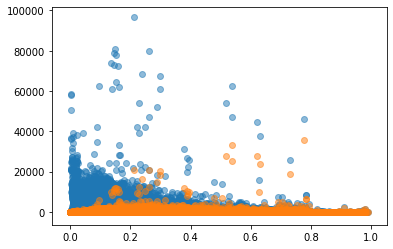

In [14]:
#Visualize how request and payment varies with percentage on one plot
plt.scatter(result.percentage, result.request, alpha=0.5)
plt.scatter(result.percentage, result.payment, alpha=0.5)

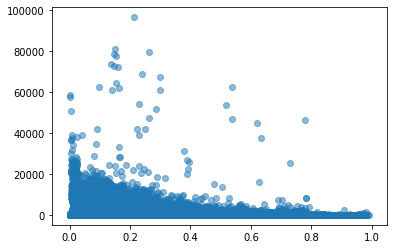

In [15]:
#Visualize how payment varies with percentage
plt.scatter(result.percentage, result.request, alpha=0.5)

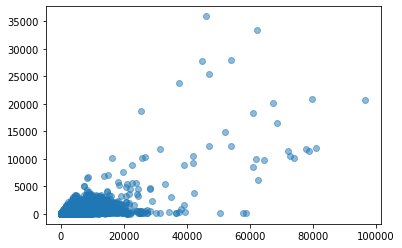

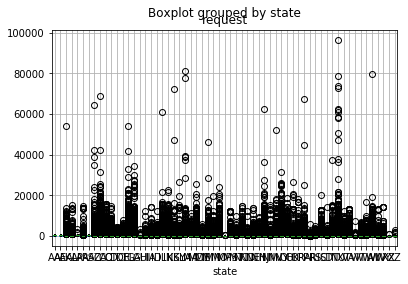

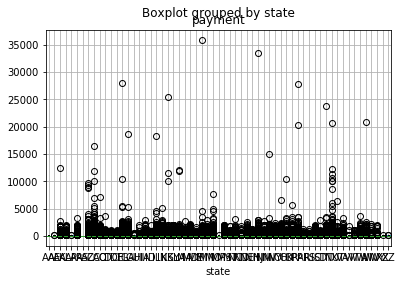

In [16]:
#Visualize request vs payment and then compared them to state
plt.scatter(result.request, result.payment, alpha=0.5)
result.boxplot(column='request', by='state')
result.boxplot(column='payment', by='state')

In [104]:
#Create new data from by grouping by state taking mean of payment and request (bystate)
bystate = df.groupby("state")["request","payment"].mean()
bystate=bystate.reset_index(drop=False)
bystate = bystate[bystate.state != 'AE']
print(bystate)
state=bystate.state


   state     request    payment
1     AK  601.685291  93.660556
2     AL  271.608212  66.991928
3     AR  262.585253  67.528151
4     AZ  369.262314  88.941337
5     CA  399.849742  91.557442
6     CO  364.474619  81.073443
7     CT  356.614855  77.330266
8     DE  380.566504  86.770384
9     FL  394.650614  89.965321
10    GA  385.330650  76.075009
11    HI  275.610377  71.156965
12    IA  276.508544  63.827732
13    ID  273.993967  66.908623
14    IL  381.020930  77.688270
15    IN  357.206391  74.331826
16    KS  312.170440  73.799186
17    KY  267.658589  65.998410
18    LA  362.782531  74.868922
19    MA  325.958870  73.196520
20    MD  355.449360  91.636462
21    ME  258.877302  65.321361
22    MI  296.539881  74.316444
23    MN  269.809372  64.454261
24    MO  343.652938  75.469823
25    MS  336.487112  66.791846
26    MT  275.077033  74.387970
27    NC  323.474536  68.306249
28    ND  273.819373  64.921363
29    NE  291.135617  67.488778
30    NH  408.248031  72.619004
31    NJ

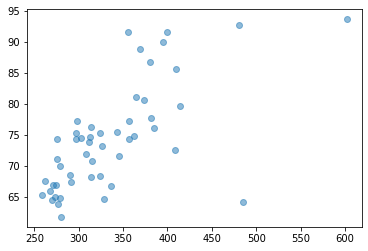

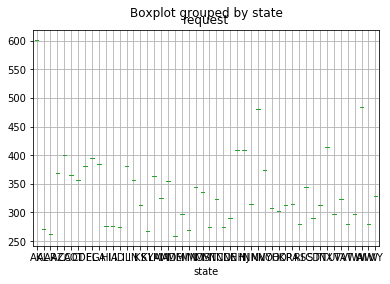

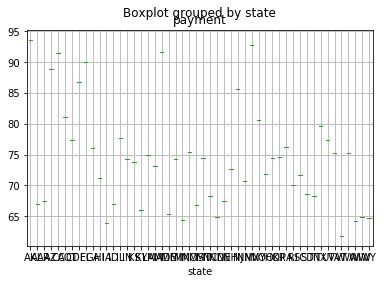

In [59]:
#Visualize the above dataframe
plt.scatter(bystate.request, bystate.payment, alpha=0.5)
bystate.boxplot(column='request', by='state')
bystate.boxplot(column='payment', by='state')

(array([ 1.,  1.,  0.,  1.,  5.,  6., 11., 12.,  8.,  5.]),
 array([0.1325276 , 0.14631743, 0.16010727, 0.1738971 , 0.18768694,
        0.20147678, 0.21526661, 0.22905645, 0.24284628, 0.25663612,
        0.27042596]),
 <a list of 10 Patch objects>)

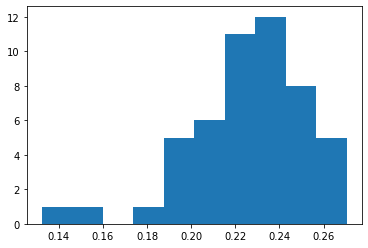

In [105]:
bystate["percentage"]=bystate["payment"]/bystate["request"]
plt.hist(bystate['percentage'])

In [77]:
scaler = preprocessing.StandardScaler().fit(bystate)
dfNorm = scaler.transform(bystate)

maxClusters = 50
sse = []
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(dfNorm)
    sse.append(kmeans.inertia_)
    
#print(sse)

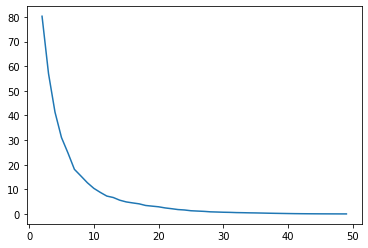

In [78]:
plt.plot(range(2,maxClusters),sse)

In [79]:
silh = []
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(dfNorm)
    silhouette_avg = silhouette_score(dfNorm, kmeans.labels_)
    silh.append(silhouette_avg)
print(silh)

[0.44663815272379087, 0.4238068299609354, 0.40858152071927883, 0.4095589438210466, 0.3339218922037872, 0.38364496044003416, 0.3770211042751398, 0.3729022573806837, 0.36698724761851004, 0.358745675033203, 0.3394090368979235, 0.32961426718978826, 0.34076256374467756, 0.3169781381455786, 0.3149884098024777, 0.3179041509593859, 0.3116702677942303, 0.32674797807613515, 0.2962195774990067, 0.3193461940251069, 0.3424371157601234, 0.34588262904500183, 0.31360484644004455, 0.34569514285234315, 0.3250125447133583, 0.3151258754746026, 0.33299835289790786, 0.3178904073959934, 0.32242318681962784, 0.3064501396092052, 0.3026871571536567, 0.2781316982905202, 0.2854710321223678, 0.24580153316740438, 0.24073025935912626, 0.23818022713744938, 0.232396071640474, 0.20816050236659442, 0.1988318230818954, 0.17726151302790047, 0.15739849381027857, 0.1334832018723699, 0.12377823323609309, 0.10244574292539443, 0.08571947540408165, 0.06367020748265766, 0.03605980086267652, 0.013165866973100293]


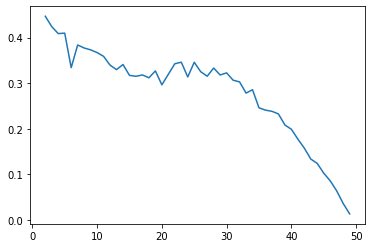

In [80]:
plt.plot(range(2,maxClusters),silh)

In [106]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(dfNorm)

In [107]:
bystate=bystate.reset_index(drop=False)

In [109]:
bystateclus = pd.concat([bystate,pd.DataFrame(kmeans.labels_,columns=["Cluster"])],axis=1)
#bystateclus=pd.concat([bystateclus,state], axis=1, join='outer', ignore_index=True)
print(bystateclus)

    index state     request    payment  percentage  Cluster
0       1    AK  601.685291  93.660556    0.155664        4
1       2    AL  271.608212  66.991928    0.246649        0
2       3    AR  262.585253  67.528151    0.257167        0
3       4    AZ  369.262314  88.941337    0.240862        1
4       5    CA  399.849742  91.557442    0.228980        1
5       6    CO  364.474619  81.073443    0.222439        1
6       7    CT  356.614855  77.330266    0.216845        3
7       8    DE  380.566504  86.770384    0.228003        1
8       9    FL  394.650614  89.965321    0.227962        1
9      10    GA  385.330650  76.075009    0.197428        3
10     11    HI  275.610377  71.156965    0.258180        0
11     12    IA  276.508544  63.827732    0.230835        0
12     13    ID  273.993967  66.908623    0.244197        0
13     14    IL  381.020930  77.688270    0.203895        3
14     15    IN  357.206391  74.331826    0.208092        3
15     16    KS  312.170440  73.799186  

In [110]:
bystateclus.drop(['index'],axis=1,inplace=True)

In [111]:
pd.set_option('display.max_rows', None)
display(bystateclus)

,state,request,payment,percentage,Cluster
0,AK,601.685291,93.660556,0.155664,4
1,AL,271.608212,66.991928,0.246649,0
2,AR,262.585253,67.528151,0.257167,0
3,AZ,369.262314,88.941337,0.240862,1
4,CA,399.849742,91.557442,0.228980,1
5,CO,364.474619,81.073443,0.222439,1
6,CT,356.614855,77.330266,0.216845,3
7,DE,380.566504,86.770384,0.228003,1
8,FL,394.650614,89.965321,0.227962,1
9,GA,385.330650,76.075009,0.197428,3


In [112]:
bystateclus['Cluster'].value_counts()
bystateclus.groupby('Cluster').mean()

,request,payment,percentage
Cluster,,,
0,288.158889,69.930969,0.242935
1,380.934337,87.022660,0.228855
2,484.618099,64.225271,0.132528
3,355.832312,72.927250,0.205661
4,540.943367,93.201825,0.174399


In [115]:
export_csv = bystateclus.to_csv (r'C:\Users\anna2\Desktop\IEMS 308\cluster.csv', index = None, header=True)